# **RNN MODEL - IMDb Dataset**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Cek apakah CUDA tersedia dan gunakan GPU jika memungkinkan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **PYTORCH**

In [3]:
# Load IMDb Dataset
num_words = 30000  # Set the max number of words for the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Pad the sequences to a fixed length
maxlen = 300
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [5]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

In [6]:
# Define the model (Complex Deep Learning Model)
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.rnn = nn.LSTM(128, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)  # Bidirectional so we multiply by 2
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take the last time step
        out = self.fc1(out)
        out = self.fc2(out)
        return self.sigmoid(out)

In [7]:
# Hyperparameters
input_dim = num_words  # Number of words in vocabulary
hidden_dim = 64  # Hidden layer dimensions
output_dim = 1  # Binary classification

In [8]:
# Initialize the model, loss function, and optimizer
model = RNNModel(input_dim, hidden_dim, output_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training loop
num_epochs = 5  # Reduced number of epochs for faster training
batch_size = 32  # Increased batch size for faster training
train_loader = DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=batch_size, shuffle=True)

In [10]:
# Track loss and accuracy for plotting
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions
        preds = outputs.squeeze().round()  # Round to get 0 or 1
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    train_loss.append(epoch_loss)
    train_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/5, Loss: 0.5924, Accuracy: 0.6658
Epoch 2/5, Loss: 0.4195, Accuracy: 0.8129
Epoch 3/5, Loss: 0.3045, Accuracy: 0.8718
Epoch 4/5, Loss: 0.2356, Accuracy: 0.9087
Epoch 5/5, Loss: 0.2439, Accuracy: 0.9022


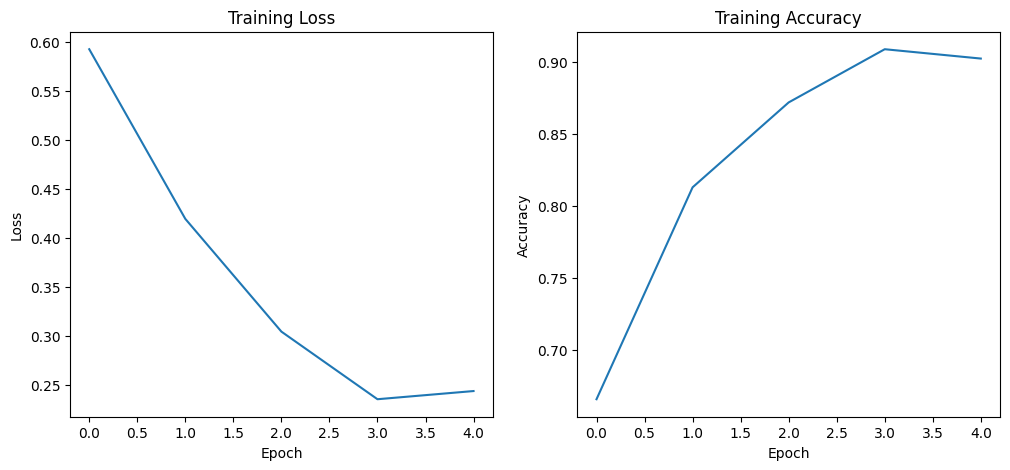

In [11]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [12]:
# Evaluate the model on test data
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in DataLoader(list(zip(x_test_tensor, y_test_tensor)), batch_size=batch_size):
        outputs = model(inputs)
        probs = outputs.squeeze().cpu().numpy()
        preds = np.round(probs)
        all_probs.extend(probs)
        all_preds.extend(preds)

In [13]:
accuracy = accuracy_score(y_test, all_preds)
precision = precision_score(y_test, all_preds)
recall = recall_score(y_test, all_preds)
f1 = f1_score(y_test, all_preds)
auc = roc_auc_score(y_test, all_probs)

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

Test Accuracy: 0.8333
Test Precision: 0.8290
Test Recall: 0.8398
Test F1 Score: 0.8344
Test AUC: 0.9030


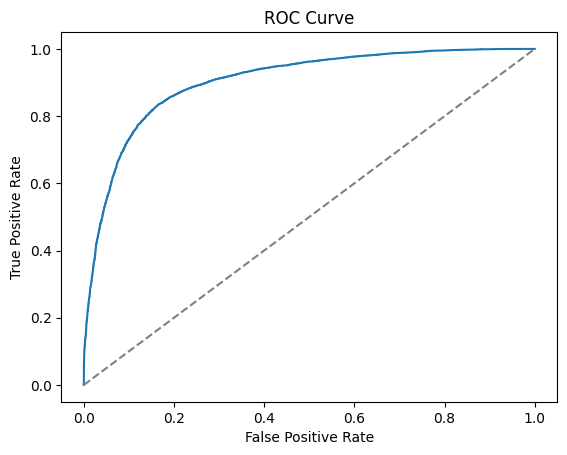

In [14]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, all_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# **TENSORFLOW**

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [16]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [17]:
# Define the model (Complex Deep Learning Model)
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(128, dropout=0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - accuracy: 0.6988 - loss: 0.5468 - val_accuracy: 0.8637 - val_loss: 0.3189
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.9204 - loss: 0.2146 - val_accuracy: 0.8481 - val_loss: 0.3848
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.9516 - loss: 0.1383 - val_accuracy: 0.8285 - val_loss: 0.4687
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9588 - loss: 0.1176 - val_accuracy: 0.8524 - val_loss: 0.4942
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.9727 - loss: 0.0813 - val_accuracy: 0.8582 - val_loss: 0.4566


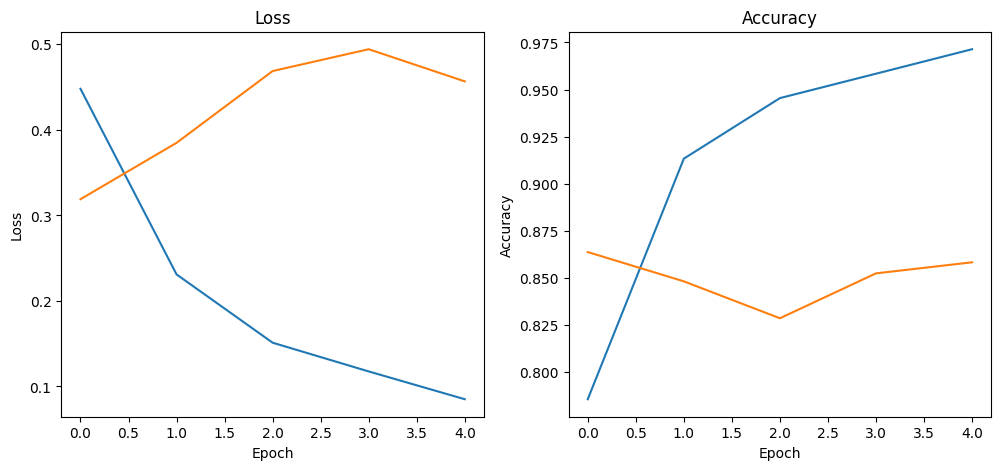

In [20]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [21]:
# Evaluate the model on test data
y_pred = (model.predict(x_test) > 0.5).astype('int32')

782/782 ━━━━━━━━━━━━━━━━━━━━ 234s 298ms/step


In [22]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

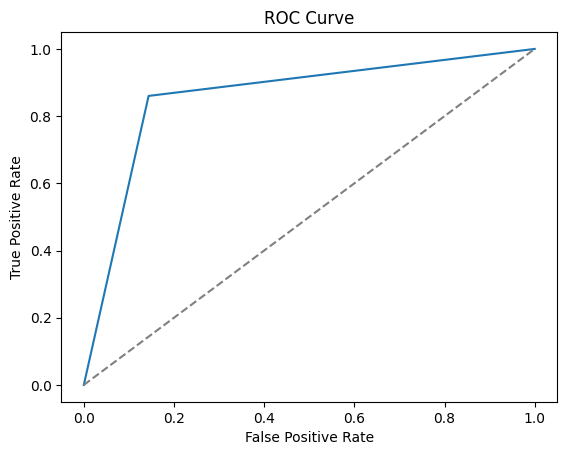

Test Accuracy: 0.8582
Test Precision: 0.8569
Test Recall: 0.8602
Test F1 Score: 0.8585
Test AUC: 0.8582


In [23]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

# **Analisis Proyek RNN Model untuk Klasifikasi Sentimen pada Dataset IMDb**

Pada proyek ini, kita mengimplementasikan model **RNN (Recurrent Neural Network)** menggunakan PyTorch dan TensorFlow untuk menganalisis sentimen ulasan film pada dataset IMDb. Tujuan dari proyek ini adalah untuk mengklasifikasikan ulasan sebagai Positif atau Negatif. Model ini di-evaluasi dengan berbagai metrik yang umum digunakan dalam tugas klasifikasi biner, yaitu Akurasi, Presisi, Recall, F1 Score, dan AUC.

#### **Hasil Evaluasi**:

##### **PyTorch**
- **Test Accuracy**: 0.8333
- **Test Precision**: 0.8290
- **Test Recall**: 0.8398
- **Test F1 Score**: 0.8344
- **Test AUC**: 0.9030

##### **TensorFlow**
- **Test Accuracy**: 0.8582
- **Test Precision**: 0.8569
- **Test Recall**: 0.8602
- **Test F1 Score**: 0.8585
- **Test AUC**: 0.8582

---

### **Penjelasan untuk Metrik Evaluasi**

#### **1. Akurasi (Accuracy)**

Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi yang dilakukan oleh model. Ini adalah metrik yang umum digunakan untuk mengukur kinerja model dalam klasifikasi.


$$\text{Accuracy} = \frac{\text{Jumlah Prediksi yang Benar}}{\text{Jumlah Total Prediksi}}$$


**Interpretasi:**
- PyTorch Test Accuracy: 0.8333 berarti 83.33% dari prediksi yang dilakukan oleh model benar.
- TensorFlow Test Accuracy: 0.8582 berarti 85.82% dari prediksi yang dilakukan oleh model benar.

Hasil ini menunjukkan bahwa model TensorFlow sedikit lebih unggul dibandingkan model PyTorch dalam hal akurasi. Namun, kedua model sudah menunjukkan kinerja yang sangat baik.

---

#### **2. Presisi (Precision)**

Presisi mengukur berapa banyak dari semua prediksi positif yang benar-benar positif. Ini sangat penting ketika kita ingin meminimalkan jumlah prediksi positif palsu.


$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$


**Interpretasi:**
- PyTorch Test Precision: 0.8290 berarti 82.90% dari semua prediksi positif yang dilakukan oleh model adalah benar.
- TensorFlow Test Precision: 0.8569 berarti 85.69% dari semua prediksi positif yang dilakukan oleh model adalah benar.

TensorFlow menunjukkan presisi yang lebih tinggi, yang berarti model lebih jarang membuat prediksi positif yang salah.

---

#### **3. Recall (Sensitivity)**

Recall mengukur seberapa banyak dari semua data positif yang dapat diprediksi dengan benar oleh model. Ini penting ketika kita ingin memastikan bahwa kita tidak melewatkan banyak contoh positif.


$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$


**Interpretasi:**
- PyTorch Test Recall: 0.8398 berarti 83.98% dari semua ulasan positif dapat diprediksi dengan benar oleh model.
- TensorFlow Test Recall: 0.8602 berarti 86.02% dari semua ulasan positif dapat diprediksi dengan benar oleh model.

TensorFlow memiliki recall yang sedikit lebih tinggi, yang menunjukkan bahwa model TensorFlow lebih baik dalam mendeteksi ulasan positif dibandingkan dengan model PyTorch.

---

#### **4. F1 Score**

F1 Score adalah rata-rata harmonis antara presisi dan recall. Ini sangat berguna ketika kita memiliki data yang tidak seimbang (misalnya lebih banyak ulasan negatif daripada positif), karena memberikan gambaran keseimbangan antara kedua metrik tersebut.


$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$


**Interpretasi:**
- PyTorch Test F1 Score: 0.8344 menunjukkan keseimbangan yang cukup baik antara presisi dan recall untuk model PyTorch.
- TensorFlow Test F1 Score: 0.8585 menunjukkan keseimbangan yang lebih baik antara presisi dan recall untuk model TensorFlow.

Hasil ini menunjukkan bahwa TensorFlow memiliki keseimbangan yang lebih baik antara presisi dan recall, yang mungkin berarti lebih sedikit kasus positif yang terlewatkan, meskipun presisi sedikit lebih rendah pada TensorFlow dibandingkan dengan PyTorch.

---

#### **5. AUC (Area Under the Curve)**

AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). Kurva ROC menunjukkan seberapa baik model dapat membedakan antara kelas positif dan negatif. AUC adalah ukuran dari kemampuan model untuk membedakan antara dua kelas. AUC yang lebih tinggi menunjukkan model yang lebih baik dalam membedakan antara kelas positif dan negatif.


$$\text{AUC} = \text{Area di bawah kurva ROC}$$


**Interpretasi:**
- PyTorch Test AUC: 0.9030 berarti model PyTorch memiliki kemampuan yang sangat baik untuk membedakan antara ulasan positif dan negatif.
- TensorFlow Test AUC: 0.8582 berarti model TensorFlow juga cukup efektif dalam membedakan antara ulasan positif dan negatif, meskipun sedikit lebih rendah dibandingkan dengan model PyTorch.

AUC yang lebih tinggi pada PyTorch menunjukkan bahwa model ini lebih efektif dalam membedakan antara ulasan positif dan negatif.

---

### **Kesimpulan**

Berdasarkan hasil evaluasi di atas, berikut adalah beberapa poin penting:

1. **Performa Model**:
   - Model TensorFlow menunjukkan akurasinya lebih tinggi dan presisi lebih baik. Namun, recall dan F1 score sedikit lebih tinggi pada model PyTorch.
   - Model PyTorch memiliki AUC lebih tinggi, yang menunjukkan bahwa model ini lebih baik dalam membedakan antara kelas positif dan negatif.

2. **Keseimbangan Precision-Recall**:
   - Model TensorFlow sedikit lebih unggul dalam presisi, tetapi model PyTorch lebih baik dalam recall dan F1 score. Hal ini menunjukkan bahwa model PyTorch lebih baik dalam mendeteksi ulasan positif (recall), sementara model TensorFlow lebih hati-hati dalam memberikan prediksi positif (presisi).

3. **AUC**:
   - Model PyTorch sedikit lebih unggul dalam hal AUC, yang mengindikasikan bahwa model PyTorch lebih efektif dalam membedakan antara kelas positif dan negatif.
